In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"

import pickle
from keychestenv_gofa import features_for_obs
from copy import deepcopy
import pandas as pd
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
data = pickle.load(open('episodes-1000-56a40a18-f9d4-11ea-9364-00155d9ed424.pkl', 'rb'))

In [3]:
def episode_to_time_series(episode):
    """Convert an episode array to a time series dictionary."""
    obs = episode[0]['observation']
    rew = 0.0
    done = False
    
    result = []
    
    def add_to_result(obs, rew, done, initial):
        item = deepcopy(features_for_obs(obs))
        item['reward'] = rew
        item['done'] = done
        item['initial'] = initial
        item['keys_and_atchest'] = (item['keys_collected'] > 0) and item['at_chest']
        item['lamp_toggle'] = item['at_button'] ^ item['lamp_state']
        del item['player_position_x']
        del item['player_position_y']
        result.append(item)
        
    add_to_result(obs, 0.0, False, True)
    
    for step in episode[1:]:
        obs, rew, done, info = step['observation'], step['reward'], step['done'], step['info']
        add_to_result(obs, rew, done, False)
        
    return result

In [4]:
data_proc = [episode_to_time_series(episode) for episode in data]

In [5]:
x_data_proc = [step for episode in data_proc for step in episode[:-1]]
y_data_proc = [step for episode in data_proc for step in episode[1:]]

In [6]:
x_data_proc_df = pd.DataFrame(x_data_proc)
y_data_proc_df = pd.DataFrame(y_data_proc)

In [7]:
del y_data_proc_df['at_food']
del y_data_proc_df['at_key']
del y_data_proc_df['at_chest']
del y_data_proc_df['at_button']
del y_data_proc_df['initial']

In [8]:
y_data_proc_df

,lamp_state,health,keys_collected,reward,done,keys_and_atchest,lamp_toggle
0,0,7.0,0.0,-0.1,False,False,0
1,0,6.0,0.0,-0.1,False,False,0
2,0,5.0,0.0,-0.1,False,False,0
3,0,9.0,0.0,0.9,False,False,0
4,0,8.0,0.0,-0.1,False,False,0
...,...,...,...,...,...,...,...
14331,0,3.0,0.0,1.9,False,False,0
14332,0,2.0,0.0,-0.1,False,False,0
14333,0,1.0,0.0,-0.1,False,False,0
14334,0,0.0,0.0,-0.1,False,False,0


In [9]:
X = np.array(x_data_proc_df, dtype=np.float32)
y = np.array(y_data_proc_df, dtype=np.float32)

In [10]:
X.shape, y.shape

((14336, 12), (14336, 7))

In [11]:
model = tf.keras.Sequential([tf.keras.Input(X.shape[1]), tf.keras.layers.Dense(y.shape[1], activation=None)])

In [12]:
model.compile('adam', 'mse')

In [13]:
h = model.fit(X, y, verbose=0, epochs=50)

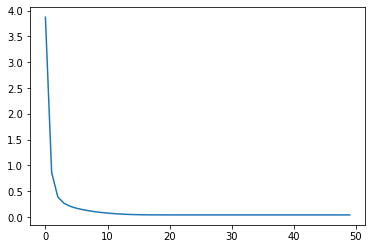

In [14]:
plt.plot(h.history['loss'])
plt.show()

In [15]:
h.history['loss'][-1]

0.03980891779065132

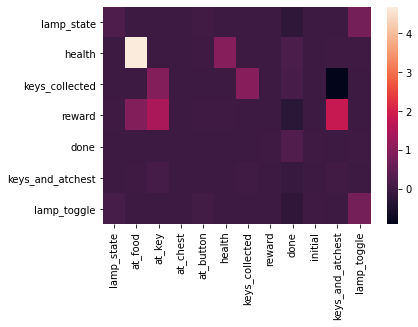

In [16]:
sns.heatmap(model.get_weights()[0].T,
            xticklabels=x_data_proc_df.columns,
            yticklabels=y_data_proc_df.columns)